In [235]:
import os
import sys
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from collections import Counter

In [236]:
conn = sqlite3.connect("/home/sumkin/sumkin-trading/data/trades.db")
cursor = conn.cursor()

# Number of trades.
q = "SELECT COUNT(*) FROM cointegration_pair_trades"
cursor.execute(q)
res = cursor.fetchone()
number_of_trades = res[0]

# Number of completed trades.
q = "SELECT COUNT(*) FROM cointegration_pair_trades WHERE active = 0"
cursor.execute(q)
res = cursor.fetchone()
number_of_completed_trades = res[0]

# Number of active trades.
q = "SELECT COUNT(*) FROM cointegration_pair_trades WHERE active = 1"
cursor.execute(q)
res = cursor.fetchone()
number_of_active_trades = res[0]

# Win rate.
q = "SELECT COUNT(*) FROM cointegration_pair_trades WHERE active = 0 AND return > 0"
cursor.execute(q)
res = cursor.fetchone()
number_of_win_trades = res[0]
win_rate = round(100 * number_of_win_trades / number_of_completed_trades, 1)

# Returns
q = "SELECT return FROM cointegration_pair_trades WHERE active = 0"
cursor.execute(q)
res = cursor.fetchall()
returns = [e[0] for e in res]

# Length of trade.
q = "SELECT ROUND((julianday(exit_dt) - julianday(enter_dt)) * 24, 2) FROM cointegration_pair_trades WHERE active = 0"
cursor.execute(q)
res = cursor.fetchall()
lengths = [e[0] for e in res]

# General statistics

In [237]:
print("Number of trades = {}".format(number_of_trades))
print("Number of completed trades = {}".format(number_of_completed_trades))
print("Number of active trades = {}".format(number_of_active_trades))
print("Win rate = {}%".format(win_rate))
print("Average return = {}".format(round(np.mean(returns),5)))
print("Sum of returns = {}".format(round(np.sum(returns), 2)))
print("Average length of trade = {}".format(round(np.mean(lengths), 2)))

Number of trades = 569
Number of completed trades = 548
Number of active trades = 21
Win rate = 51.1%
Average return = 0.01113
Sum of returns = 6.1
Average length of trade = 9.13


# Return distribution

In [238]:
fig = go.Figure(data=[
    go.Histogram(
        x=returns,
        nbinsx=50,
        marker_color="skyblue",
        opacity=0.7,
        marker_line_color="black",
        marker_line_width=1
    )
])
fig.update_layout(title = "Absolute return distribution")
fig.show()

Prepare dataframe for the analysis.

In [239]:
df = pd.read_sql_query("SELECT * FROM cointegration_pair_trades WHERE active = 0", conn)
subdf = df[["side", "hedge", "coeff", "sigma", "return_pct", "return", "p1_enter", "p1_exit", "p2_enter", "p2_exit"]].copy()
subdf["v_enter"] = subdf["p2_enter"] - subdf["hedge"] * subdf["p1_enter"]
subdf["v_exit"] = subdf["p2_exit"] - subdf["hedge"] * subdf["p1_exit"]
subdf["v_enter_coeff"] = subdf["v_enter"] - subdf["coeff"]
subdf["v_exit_coeff"] = subdf["v_exit"] - subdf["coeff"]
subdf_buy = subdf[subdf["side"] == "BUY"].copy()
subdf_sell = subdf[subdf["side"] == "SELL"].copy()
subdf_buy["return_pct"] = (subdf["v_exit"] - subdf["v_enter"]) / abs(subdf["v_enter"])
subdf_sell["return_pct"] = (subdf["v_enter"] - subdf["v_exit"]) / abs(subdf["v_enter"])
subdf_buy["v_enter_coeff_div_sigma"] = subdf_buy["v_enter_coeff"] / subdf["sigma"]
subdf_sell["v_enter_coeff_div_sigma"] = subdf_sell["v_enter_coeff"] / subdf["sigma"]

In [240]:
subdf_buy[abs(subdf_buy["return_pct"]) > 2].head(10)

,side,hedge,coeff,sigma,return_pct,return,p1_enter,p1_exit,p2_enter,p2_exit,v_enter,v_exit,v_enter_coeff,v_exit_coeff,v_enter_coeff_div_sigma
6,BUY,0.383302,-0.068727,0.037242,412.635644,0.062066,5.23700,5.22300,2.00720,2.06390,-0.000150,0.061916,0.068576,0.130643,1.841374
189,BUY,0.365438,-0.016373,0.008539,21.748242,0.010377,0.81600,0.80260,0.29772,0.30320,-0.000477,0.009900,0.015896,0.026273,1.861628
197,BUY,0.434576,-0.027623,0.022977,-3.925624,-0.040958,2.49270,2.54990,1.09370,1.07760,0.010433,-0.030524,0.038057,-0.002901,1.656289
267,BUY,0.435144,-0.008171,0.006247,6.427790,0.009975,0.52920,0.52450,0.23183,0.23976,0.001552,0.011527,0.009722,0.019698,1.556309
297,BUY,0.932615,-0.016705,0.009616,-2.710634,-0.026935,0.26277,0.28125,0.25500,0.24530,0.009937,-0.016998,0.026642,-0.000293,2.770493
369,BUY,0.317069,-0.019141,0.009424,7.231706,0.013359,2.57520,2.52720,0.81467,0.81281,-0.001847,0.011512,0.017294,0.030653,1.835100
399,BUY,0.219989,-0.011395,0.005537,-3.469936,-0.009566,2.56130,2.52160,0.56070,0.54240,-0.002757,-0.012323,0.008638,-0.000928,1.559978


In [241]:
subdf_sell[abs(subdf_sell["return_pct"]) > 2].head(10)

,side,hedge,coeff,sigma,return_pct,return,p1_enter,p1_exit,p2_enter,p2_exit,v_enter,v_exit,v_enter_coeff,v_exit_coeff,v_enter_coeff_div_sigma
90,SELL,0.556932,0.011208,0.004818,3.223030,0.012476,0.69730,0.70040,0.39222,0.38147,0.003871,-0.008605,-0.007337,-0.019813,-1.522806
111,SELL,0.698822,0.002709,0.001398,4.418166,0.002280,0.31080,0.31080,0.21771,0.21543,0.000516,-0.001764,-0.002193,-0.004473,-1.567838
178,SELL,0.786430,0.033567,0.020151,5.218807,0.023053,1.09230,1.09580,0.85460,0.83430,-0.004417,-0.027470,-0.037984,-0.061036,-1.884910
240,SELL,0.576165,0.008535,0.003953,-4.824494,-0.009773,0.30978,0.30712,0.18051,0.18875,0.002026,0.011798,-0.006509,0.003264,-1.646652
528,SELL,0.222540,0.088205,0.034512,2.158080,0.058430,13.00000,12.88600,2.92010,2.83630,0.027075,-0.031355,-0.061130,-0.119560,-1.771271


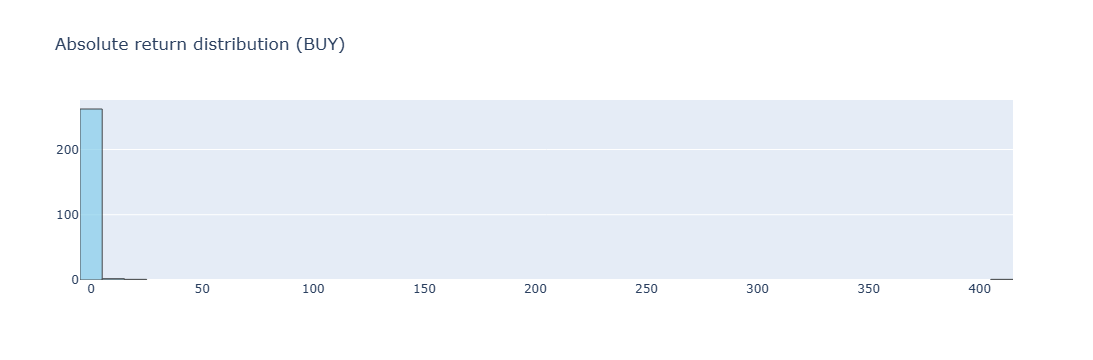

In [242]:
fig = go.Figure(data=[
    go.Histogram(
        x=subdf_buy["return_pct"],
        nbinsx=50,
        marker_color="skyblue",
        opacity=0.7,
        marker_line_color="black",
        marker_line_width=1
    )
])
fig.update_layout(title = "Absolute return distribution (BUY)")
fig.show()

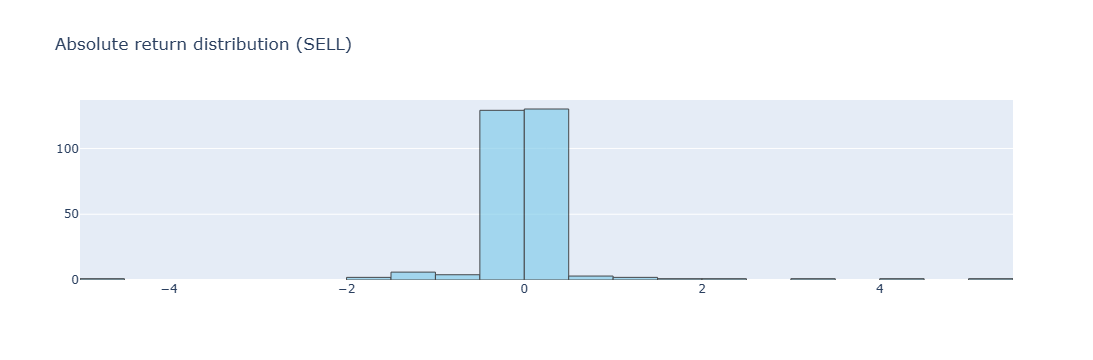

In [243]:
fig = go.Figure(data=[
    go.Histogram(
        x=subdf_sell["return_pct"],
        nbinsx=50,
        marker_color="skyblue",
        opacity=0.7,
        marker_line_color="black",
        marker_line_width=1
    )
])
fig.update_layout(title = "Absolute return distribution (SELL)")
fig.show()